### Libraries

In [1]:
import sys
sys.path.insert(0, '/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [2]:
report_dict = {}

In [3]:
date_start = '2018-04-01'
date_end = '2019-04-30'

write_pdf = 'yes'

ym = pd.DataFrame({'year and month':pd.date_range(date_start, date_end, freq = 'MS')})
ym['year and month'] = [str(x)[:7] for x in ym['year and month']]
ym.set_index('year and month', inplace = True)

pretty_dates = [calendar.month_abbr[int(str(x)[5:7])] + '\n' + str(x)[:4] for x in ym.index]

csv_path = r'/Users/jarad/Fake Folder/Finance/Recurring/PayPal Monthly Audit/CSVs/Monthly CSV Statements/'

image_path = '/Users/jarad/Fake Folder/Finance/Recurring/PayPal Monthly Audit/Images/'

html_path = '/Users/jarad/Fake Folder/Finance/Recurring/PayPal Monthly Audit/HTML/'
html_title = 'PayPal Monthly Audit.html'

style_sheet_path = '/Users/jarad/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

pdf_path = '/Users/jarad/Fake Folder/Finance/Recurring/PayPal Monthly Audit/Docs/Monthly Reports/'

now_pretty = str(dt.datetime.now().date())

### Chart settings

In [4]:
colors = ['#0c2577',
          '#4a7184',
          '#8592bb',
          '#06123b']

fc = '#dfe3ee'

#plt.rcdefaults()
#plt.rcParams.keys()

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['legend.fontsize'] = 20

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif'] = 'Arial'

plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

### View payment module codes

In [5]:
pd.read_sql(
'''
SELECT
DISTINCT payment_module_code
FROM orders
ORDER BY payment_module_code
''', db)

,payment_module_code
0,adabox_subscribe
1,authorizenet
2,authorizenet_aim
3,authorizenet_cim
4,bitpay
5,googlecheckout
6,GV/DC
7,gwib
8,lapwa
9,moneyorder


### Note that we no longer use this one

In [6]:
pd.read_sql(
'''
SELECT
MIN(DATE(date_purchased)),
MAX(DATE(date_purchased))
FROM orders
WHERE payment_module_code = 'paypal'
''', db)

,MIN(DATE(date_purchased)),MAX(DATE(date_purchased))
0,2005-10-12,2009-08-08


### We use this one now

In [7]:
pd.read_sql(
'''
SELECT
MIN(DATE(date_purchased)),
MAX(DATE(date_purchased))
FROM orders
WHERE payment_module_code = 'paypalwpp'
''', db)

,MIN(DATE(date_purchased)),MAX(DATE(date_purchased))
0,2009-08-09,2019-05-07


### Get db data

In [8]:
os = pd.read_sql(
'''
SELECT
orders_status_id,
orders_status_name
FROM orders_status
''', db)

bs = pd.read_sql(
'''
SELECT
bs_status_id,
bs_status_name
FROM billing_status
''',db)

o_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
orders_id,
order_total AS db_order_total,
orders_status,
orders_billing_status,
'no' AS 'deleted'
FROM orders
WHERE payment_module_code IN ('paypalwpp','paypal')
''', db)

od_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
orders_id,
order_total AS db_order_total,
orders_status,
orders_billing_status,
'yes' AS 'deleted'
FROM orders_deleted od
WHERE od.payment_module_code IN ('paypalwpp','paypal')
''', db)

for df in [os, bs, o_main, od_main]:
    col_fix(df)

### Structure it

In [9]:
# make one dataframe    
orders_main = pd.concat([o_main, od_main], sort = True)
orders_main.reset_index(drop = True, inplace = True)

orders_main['date purchased'] = pd.to_datetime(orders_main['date purchased'])
orders_main['year and month purchased'] = [str(x)[:7] for x in orders_main['date purchased']]

orders_main['orders status name'] = orders_main['orders status'].map(dict(zip(os['orders status id'], os['orders status name'])))
orders_main['billing status name'] = orders_main['orders billing status'].map(dict(zip(bs['bs status id'], bs['bs status name'])))

for col in ['orders status','orders billing status']:
    orders_main.drop(col, 1, inplace = True)
    
for col in ['orders status name','billing status name']:
    orders_main[col] = [x.lower() for x in orders_main[col]]

# get dupes
dupes = orders_main[orders_main['orders id'].duplicated()]
print('%i oid dupe(s)\ndrop them' % len(dupes))

# store and drop them
orders_main_dupes = orders_main[orders_main['orders id'].isin(dupes['orders id'].tolist())].sort_values('orders id')
orders_main.drop_duplicates('orders id', inplace = True)

9 oid dupe(s)
drop them


### Get PayPal db data

In [10]:
pp_super_main = pd.read_sql(
'''
SELECT
# subtract 4 hours from this datetime to convert it into PST time
DATE(DATE_SUB(payment_date, INTERVAL 4 HOUR)) AS date_payment,
TIME(DATE_SUB(payment_date, INTERVAL 4 HOUR)) AS time_payment,
parent_txn_id,
txn_id,
order_id AS orders_id,
payment_status,
txn_type,
mc_currency AS currency,
mc_gross AS pp_order_total,
mc_fee AS pp_fee
FROM paypal
''', db)

col_fix(pp_super_main)

# dates
pp_super_main['year and month payment'] = [str(x)[:7] for x in pp_super_main['date payment']]
pp_super_main['date payment'] = pd.to_datetime(pp_super_main['date payment'], errors = 'coerce')

# make this nice
pp_super_main['payment status'] = pp_super_main['payment status'].str.lower()
pp_super_main['payment status'] = np.where(pp_super_main['payment status'].str.contains('pending'), 'pending', pp_super_main['payment status'])
pp_super_main['payment status'] = pp_super_main['payment status'].str.replace('canceled_reversal', 'canceled reversal')

# and this too
pp_super_main['txn type'] = pp_super_main['txn type'].str.replace('_',' ')

# if the txn id is an empty string, replace with the parent txn id
pp_super_main['txn id'] = np.where(pp_super_main['txn id'] == '', pp_super_main['parent txn id'], pp_super_main['txn id'])

### Make a copy and structure it

In [11]:
# make a copy
pp_main = pp_super_main.copy()

# get and remove dupes
dupes = pp_main[pp_main.duplicated()]
print('%i dupe(s)\nremove them' % len(dupes))
pp_main.drop_duplicates(inplace = True)

# get nulls
nulls1 = pp_main[pp_main.isnull().any(1)]
print('\n%i null(s)\nremove them' % len(nulls1))
pp_main.dropna(inplace = True)

cols = orders_main.columns.tolist()
cols.remove('orders id')

74 dupe(s)
remove them

28 null(s)
remove them


### Map orders data to paypal data

In [12]:
for c in cols:
    pp_main[c] = pp_main['orders id'].map(dict(zip(orders_main['orders id'], orders_main[c])))

### Restrict by date purchased

In [13]:
pp_main = pp_main[pp_main['date purchased'].between(date_start, date_end)].copy()
pp_main.reset_index(drop = True, inplace = True)

### Check db order total nulls
Make sure these are truly not in the db

In [14]:
nulls = pp_main[pp_main['db order total'].isnull()]
oids = nulls['orders id'].tolist()

if nulls.empty == False:

    a = pd.read_sql(
    '''
    SELECT
    COUNT(*)
    FROM orders
    WHERE orders_id IN '''+ str(tuple(oids)) +'''
    ''', db)

    b = pd.read_sql(
    '''
    SELECT
    COUNT(*)
    FROM orders_deleted
    WHERE orders_id IN '''+ str(tuple(oids)) +'''
    ''', db)

    if a.values[0][0] + b.values[0][0] == 0:
        pass
    else:
        raise ValueError('you are missing some OIDs')

    d = str(nulls['date payment'].max().date())
    if d > date_start:
        raise ValueError('some nulls have payment dates within the last year; check this')    

### Reconcile database PayPal and Orders data

In [15]:
rec = pp_main[(np.abs(pp_main['db order total'] - pp_main['pp order total']) > 0.05)
             & (pp_main['date purchased'] <= date_end)].copy()
rec['diff'] = rec['db order total'] - rec['pp order total']

rec2 = rec.groupby(['year and month payment','billing status name','payment status'])[['diff']].sum()

display(rec2[rec2.index.get_level_values(0) == date_end[:7]].format_(['m0']))

Diff
year and month payment billing status name payment status            
2019-04                charged             canceled reversal      $11
                                           completed               $4
                                           refunded              $933
                                           reversed              $869
                       refunded            completed             $-49
                                           refunded           $19,681
                                           reversed               $48

### Give each billing status name its own check

In [16]:
ls = list(set(pp_main['billing status name']))
for x in ls:
    
    if x == 'refunded': # ok to have mismatches when dealing with refunds
        pass
    
    elif x == 'not set':
        d = str(rec[rec['billing status name'] == x]['date payment'].max().date())
        if d < date_start:
            pass # if the latest entry is before our date start, move on
        else:
            raise ValueError('date of "not set" entry less than one year old')
        
    elif x == 'charged':
        df = rec[(rec['billing status name'] == x) & (rec['payment status'] == 'completed')] # we only care about where these two conditions are met
        n = len(df)
        t = len(pp_main)
        p = 0.002
        if n/t < p:
            pass # some mismatches are imminent because CSP freely recalculate totals, so if this proportion is less than 0.2% of the total count, move on
        else:
            raise ValueError('proportion of "charged" labels greater than {:,.1f}%'.format(p *100))
        
    elif x == 'payment received':
        df = rec[rec['billing status name'] == x]
        s = set(df['payment status'])
        if 'completed' not in s: # these should all be refunds or denied, if there is a "completed", then check it; mismatches with refunds or denied are ok
            pass 
        else:
            raise ValueError('check where billing status name is "payment received" and payment status is "completed"')
    
    else:
        pass

# Note
At this point, database data has been reconciled where applicable

### Payment status by year and month

In [17]:
gr = pp_main.groupby(['year and month purchased','payment status'])[['pp order total']].sum().unstack(1).fillna(0)
gr.columns = gr.columns.droplevel(0)
gr = gr.tail(13)

fmt = ['m0'] * len(gr.columns)
display(jb_mean(gr, fmt))
gr.format_(fmt)

,mean
Canceled Reversal,$356
Completed,"$709,938"
Pending,$299
Refunded,"$-12,426"
Reversed,$-607


,Canceled Reversal,Completed,Pending,Refunded,Reversed
year and month purchased,,,,,
2018-04,$123,"$760,688",$0,"$-12,639",$-223
2018-05,$376,"$739,550",$0,"$-13,271",$-692
2018-06,$561,"$667,804",$0,"$-13,717",$-561
2018-07,"$1,977","$658,457",$32,"$-12,296","$-4,046"
2018-08,$64,"$667,811",$0,"$-9,210",$-64
2018-09,$205,"$630,499",$0,"$-12,785",$-539
2018-10,$207,"$716,935","$2,156","$-20,193",$-274
2018-11,$132,"$799,255",$0,"$-15,206",$-160
2018-12,$207,"$732,532",$0,"$-11,388",$-166


### Get PayPal CSV data

In [18]:
all_files = glob.glob(csv_path + '/*.CSV')
frame = pd.DataFrame()
list_ = []

for file_ in all_files:
    df = pd.read_csv(file_, error_bad_lines = False)
    list_.append(df)
    
csv_super_main = pd.concat(list_)  

### Structure and clean it

In [19]:
# check for dupes
print('%i dupe(s)' % np.sum(csv_super_main.duplicated()))
csv_super_main.drop_duplicates(inplace = True)
csv_super_main.reset_index(drop = True, inplace = True)

# columns clean
csv_super_main.columns = csv_super_main.columns.str.lower()
csv_super_main.columns = csv_super_main.columns.str.strip()
csv_super_main.rename(columns = {'gross':'csv gross',
                                 'fee':'csv fee',
                                 'net':'csv net',
                                 'date':'date payment pst',  # CSV dates are pacific time
                                 'transaction id':'txn id',
                                 'reference txn id':'parent txn id'}, inplace = True)

# get est date and time column
csv_super_main['date payment pst'] = pd.to_datetime(csv_super_main['date payment pst'])
csv_super_main['date and time payment pst'] = pd.to_datetime((csv_super_main['date payment pst'].map(str)).str[:10] + ' ' + csv_super_main['time'].map(str))
csv_super_main['date and time payment est'] = csv_super_main['date and time payment pst'] + pd.DateOffset(hours = 3)

# get other date columns
for col in ['pst','est']:
    csv_super_main['date payment ' + col] = [x.date() for x in csv_super_main['date and time payment ' + col]]
    csv_super_main['year and month payment ' + col] = [str(x)[:7] for x in csv_super_main['date and time payment ' + col]]

# to number    
ls = ['csv gross',
     'csv fee',
     'csv net',
     'shipping and handling amount',
     'insurance amount',
     'sales tax']

for col in ls:
    try:
        csv_super_main[col] = csv_super_main[col].str.replace(',','')
        csv_super_main[col] = pd.to_numeric(csv_super_main[col])
    except:
        pass
    
# get fees
csv_super_main['csv fee'] = csv_super_main['csv gross'] - csv_super_main['csv net']       

# to lowercase
ls = ['from email address',
      'to email address',
      'status',
      'type',
      'balance impact',
      'balance impact']

for col in ls:
    csv_super_main[col] = csv_super_main[col].str.lower()      
    
# the parent txn id is equal to the txn id when the data is just one line
csv_super_main['parent txn id'].fillna(csv_super_main['txn id'], inplace = True)

csv_super_main['date payment pst'] = pd.to_datetime(csv_super_main['date payment pst'])

0 dupe(s)


### Fix non-usd currency
Most of these non-USD currencies are of type "general payment"

In [20]:
csv_super_main[csv_super_main['currency'] != 'USD']['type'].value_counts()

general currency conversion    72
general payment                60
subscription payment           13
payment refund                  2
express checkout payment        1
Name: type, dtype: int64

In [21]:
csv_super_main.drop(csv_super_main[csv_super_main['currency'] != 'USD'].index, inplace = True)
csv_super_main.reset_index(drop = True, inplace = True)

def label_fix(x):
    if x['type'] != 'general currency conversion':
        ret = x['type']
    else:
        if x['csv gross'] > 0:
            ret = 'payment refund'
        else:
            ret = 'general payment'
    return ret

csv_super_main['type'] = csv_super_main.apply(label_fix, axis = 1)

### Reconcile CSV with database

In [22]:
pp_main['csv gross'] = pp_main['txn id'].map(dict(zip(csv_super_main['txn id'], csv_super_main['csv gross'])))    

if pp_main[(pp_main['csv gross'].isnull()) & (pp_main['billing status name'] != 'refunded')].empty:
    pass
else:
    raise ValueError('you have nulls in your "csv gross" column after mapping from database')

In [23]:
rec = pp_main[np.abs(np.abs(pp_main['pp order total']) - np.abs(pp_main['csv gross'])) > 0.05]

vc = rec['billing status name'].value_counts()
for x in vc.index:
    if x == 'charged':
        raise ValueError('you have mismatches where label is "charged"')

### Assemble summary table to match Paypal website
* PayPal website > financial summaries > monthly sales > choose month
* Note that this is just for viewing purposes and is not used anywhere else in this audit

In [24]:
csv_main_pst = csv_super_main[csv_super_main['date payment pst'].between(date_start, date_end)].copy()

In [25]:
amount_types = ['express checkout payment',
                'general payment',
                'mobile payment',
                'website payment']

amounts_main = csv_main_pst[(csv_main_pst['balance impact'] == 'credit')
                          & (csv_main_pst['type'].isin(amount_types))].copy()

amounts = amounts_main.groupby('year and month payment pst').agg({'csv gross':['count','sum']})
amounts.columns = amounts.columns.droplevel(0)
amounts.rename(columns = {'count':'payments received','sum':'amount received'}, inplace = True)

In [26]:
fees_main = csv_main_pst[csv_main_pst['balance impact'] == 'credit'].copy()

fees = fees_main.groupby('year and month payment pst')[['csv fee']].sum()
fees.columns = ['fees']
fees['fees'] = fees['fees'] * -1

In [27]:
# note that here we use csv_super_main, not csv_super_main_pst
refunds_super_main = csv_super_main[(csv_super_main['balance impact'] != 'memo')
                      & (csv_super_main['type'] == 'payment refund')
                      & (csv_super_main['date payment pst'].between(date_start, date_end))].copy()

refunds = refunds_super_main.groupby('year and month payment pst').agg({'txn id':'nunique','csv gross':'sum','csv fee':'sum'})
refunds.columns = ['refunds sent','amount refunded','refunded fees']
refunds['refunded fees'] = refunds['refunded fees'] * -1

In [28]:
payments_sent_main = csv_main_pst[(csv_main_pst['balance impact'] == 'debit')
                                & (csv_main_pst['type'] == 'general payment')].copy()

payments_sent = payments_sent_main.groupby('year and month payment pst').agg({'csv gross':['count','sum']})
payments_sent.columns = ['payments sent','amount sent']

In [29]:
other_debits_main = csv_main_pst[(csv_main_pst['balance impact'] == 'debit')
                               & (~csv_main_pst['type'].isin(['general payment','payment refund']))].copy()

other_debits = other_debits_main.groupby('year and month payment pst').agg({'csv gross':'sum'})
other_debits.columns = ['other debits']

In [30]:
other_credits_main = csv_main_pst[(csv_main_pst['balance impact'] == 'credit')
                                & (~csv_main_pst['type'].isin(amount_types))].copy()

other_credits = other_credits_main.groupby('year and month payment pst').agg({'csv gross':'sum'})
other_credits.columns = ['other credits']

In [31]:
summary = amounts.join(fees).join(refunds).join(payments_sent).join(other_debits).join(other_credits)

ls = ['amount received','fees','amount refunded','refunded fees','amount sent','other debits','other credits']

summary['net amount'] = summary[ls].sum(1)

summary.format_(['n0','m2','m2','n0','m2','m2','n0','m2','m2','m2','m2'])

,Payments Received,Amount Received,Fees,Refunds Sent,Amount Refunded,Refunded Fees,Payments Sent,Amount Sent,Other Debits,Other Credits,Net Amount
year and month payment pst,,,,,,,,,,,
2018-04,"7,893","$762,160.76","$-18,772.10",161,"$-14,228.16",$322.54,18,"$-34,811.70","$-693,236.19",$207.51,"$1,642.66"
2018-05,"7,462","$740,621.12","$-18,431.08",111,"$-12,242.05",$295.46,20,"$-22,291.11","$-686,766.13",$562.88,"$1,749.09"
2018-06,"6,707","$666,432.20","$-16,481.01",82,"$-15,963.23",$395.15,23,"$-41,731.03","$-596,884.78","$1,763.70","$-2,469.00"
2018-07,"6,601","$660,199.32","$-16,244.03",97,"$-11,486.06",$284.34,11,"$-18,681.67","$-614,750.13","$2,549.53","$1,871.30"
2018-08,"6,734","$665,967.76","$-16,518.46",110,"$-9,205.17",$210.21,16,"$-24,849.41","$-619,699.93",$878.75,"$-3,216.25"
2018-09,"6,393","$631,989.70","$-15,600.21",101,"$-10,633.22",$245.37,10,"$-13,409.37","$-591,341.99","$1,150.45","$2,400.73"
2018-10,"6,962","$718,252.16","$-17,684.13",128,"$-7,876.56",$159.85,10,"$-22,993.24","$-676,394.45","$6,228.11",$-308.26
2018-11,"7,877","$799,022.22","$-19,659.24",133,"$-28,343.48",$613.58,19,"$-28,376.77","$-725,131.75",$834.57,"$-1,040.87"
2018-12,"7,416","$733,284.62","$-17,861.28",122,"$-13,373.59",$293.11,11,"$-25,881.17","$-676,484.27",$320.02,$297.44


# Official Audit Below

In [32]:
ot = pd.read_sql(
'''
SELECT
DATE_FORMAT(o.date_purchased, '%Y-%m') As year_and_month,
SUM(ot.value) AS monthly_total
FROM orders_total ot
JOIN orders o ON ot.orders_id = o.orders_id
AND DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND orders_status NOT IN (8,9,10,11,12,14,15)
AND payment_method != 'Replacement Order'
WHERE ot.class = 'ot_subtotal'
GROUP BY DATE_FORMAT(o.date_purchased, '%Y-%m')
''', db)

col_fix(ot)

### Amount received

In [33]:
df = amounts_main.groupby(['year and month payment pst','type']).agg({'csv gross':'sum'}).unstack(1).fillna(0)
df.columns = df.columns.droplevel(0)
df['total'] = df.sum(1)

df = df.join(amounts_main[amounts_main['type'] == 'express checkout payment'].groupby('year and month payment pst').agg({'csv gross':'count'}))
df.rename(columns = {'csv gross':'customer OID count'}, inplace = True)
df['avg order value'] = df['express checkout payment']/df['customer OID count']

df = df.join(ot.set_index('year and month'))
df['paypal total as % of monthly total'] = df['total']/df['monthly total']

revenue = df.copy()

fmt = ['m2','m2','m2','m2','n0','m2','m2','p1']

m = jb_mean(revenue, fmt)
yoy = jb_yoy(revenue)
display(m.join(yoy))
revenue.format_(fmt).replace('nan%','')

,mean,yoy
Express Checkout Payment,"$710,299.80",-12.13%
General Payment,$701.22,-100.00%
Mobile Payment,$6.27,
Total,"$711,007.28",-12.19%
Customer OID Count,"7,215",-12.74%
Avg Order Value,$98.52,0.70%
Monthly Total,"$3,591,199.34",-8.65%
Paypal Total As % Of Monthly Total,20.0%,-3.88%


,Express Checkout Payment,General Payment,Mobile Payment,Total,Customer OID Count,Avg Order Value,Monthly Total,Paypal Total As % Of Monthly Total
year and month payment pst,,,,,,,,
2018-04,"$761,629.76",$531.00,$0.00,"$762,160.76","7,891",$96.52,"$3,705,274.81",20.6%
2018-05,"$740,621.12",$0.00,$0.00,"$740,621.12","7,462",$99.25,"$3,870,682.25",19.1%
2018-06,"$666,241.38",$175.82,$15.00,"$666,432.20","6,703",$99.39,"$3,272,794.31",20.4%
2018-07,"$660,080.74",$102.58,$16.00,"$660,199.32","6,595",$100.09,"$3,448,739.19",19.1%
2018-08,"$665,876.02",$91.74,$0.00,"$665,967.76","6,732",$98.91,"$3,141,296.40",21.2%
2018-09,"$631,829.55",$144.15,$16.00,"$631,989.70","6,389",$98.89,"$3,081,400.30",20.5%
2018-10,"$718,120.64",$115.62,$15.90,"$718,252.16","6,956",$103.24,"$4,167,395.07",17.2%
2018-11,"$798,903.19",$119.03,$0.00,"$799,022.22","7,875",$101.45,"$3,882,480.43",20.6%
2018-12,"$733,005.94",$262.68,$16.00,"$733,284.62","7,411",$98.91,"$3,152,746.67",23.3%


### For report: revenue and AOV

In [34]:
a = revenue.iloc[-1]['total']
b = revenue.iloc[0]['total']
c = a/b-1

w1 = 'PayPal revenue {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                      np.abs(c) * 100,
                                                                                      'down' if c < 0 else 'up',
                                                                                      b,
                                                                                      a)
report_dict['revenue write'] = w1

a = revenue.iloc[-1]['paypal total as % of monthly total']
b = revenue['paypal total as % of monthly total'].mean()

if np.abs(a-b) < 0.02:
    res = 'about equal to'
else:
    if a < b:
        res = 'below'
    else:
        res = 'above'

w2 = 'As a proportion of total monthly revenue, PayPal constituted {:,.1f}%, {} the average of {:,.1f}%.'.format(a * 100,
                                                                                                               res,
                                                                                                               b * 100)
report_dict['proportion write'] = w2

a = revenue.iloc[-1]['avg order value']
b = revenue.iloc[0]['avg order value']
c = a/b-1
w3 = 'The average order value (AOV) {} {:,.1f}% year over year, {} from ${:,.2f} to ${:,.2f}.'.format('fell' if c < 0 else 'rose',
                                                                                                     np.abs(c) * 100,
                                                                                                     'down' if c < 0 else 'up',
                                                                                                     b,
                                                                                                     a)

report_dict['aov write'] = w3
print('\n'.join([w1,w2,w3]))

PayPal revenue decreased 12.2% year over year, down from $762,161 to $669,263.
As a proportion of total monthly revenue, PayPal constituted 19.8%, about equal to the average of 20.0%.
The average order value (AOV) rose 0.7% year over year, up from $96.52 to $97.19.


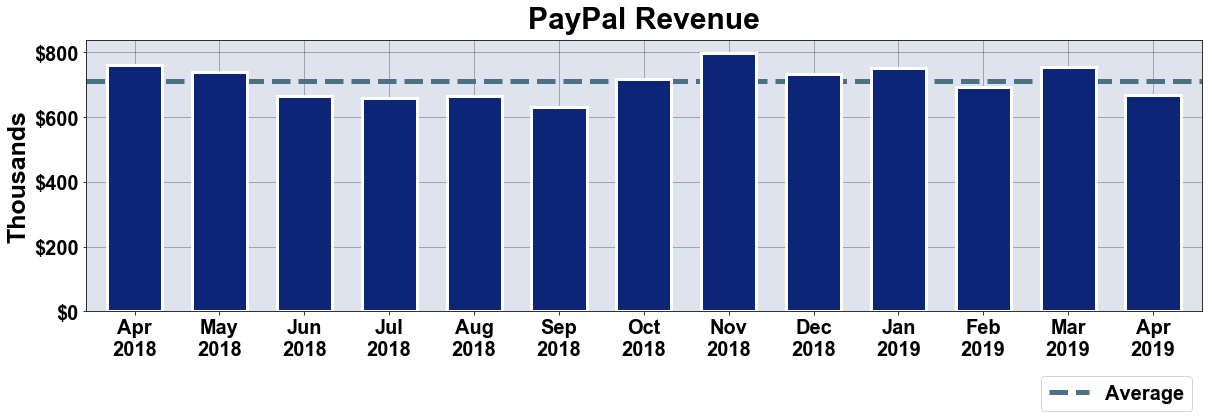

In [35]:
fig, ax = plt.subplots(figsize = (20,5))

revenue['total'].plot(kind = 'bar',
                width = 0.65,
                color = colors[0],
                edgecolor = 'white',
                lw = 3,
                label = 'Total',
                zorder = 5)

ax.axhline(revenue['total'].mean(), color = colors[1], ls = '--', label = 'Average')

ax.set_title('PayPal Revenue', y = 1.02)
ax.set_xlabel('')
ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()])
ax.set_ylabel('Thousands')
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.set_facecolor(fc)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)
ax.legend(['Average'], bbox_to_anchor = (1, -0.2))

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

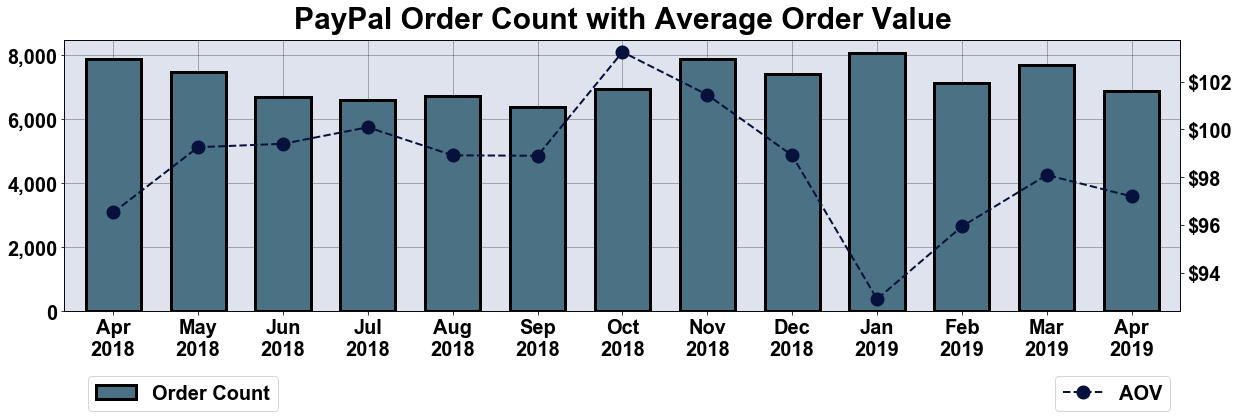

In [36]:
fig, ax = plt.subplots(figsize = (20,5))

revenue['customer OID count'].plot(kind = 'bar',
                              width = 0.65,
                              lw = 3,
                              color = colors[1],
                              edgecolor = 'black',
                              zorder = 5)

ax.set_title('PayPal Order Count with Average Order Value', y = 1.02)
ax.set_xlabel('')
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_facecolor(fc)
ax.legend(['Order Count'], bbox_to_anchor = (0.2, -0.2))

ax2 = ax.twinx()
revenue['avg order value'].plot(color = colors[3], lw = 2, ls = '--', marker = 'o', mew = 8)
ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
ax2.legend(['AOV'], bbox_to_anchor = (1, -0.2))
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Fees

In [37]:
df = summary[['amount received','fees','refunded fees']].copy()
df['fees'] = df['fees'] * -1
df['fees as % of amount received'] = df['fees']/df['amount received']

fees = df.copy()

fmt = ['m2'] * 3 + ['p1']
display(jb_mean(fees, fmt))
fees.format_(fmt)

,mean
Amount Received,"$711,007.28"
Fees,"$17,454.64"
Refunded Fees,$291.04
Fees As % Of Amount Received,2.5%


,Amount Received,Fees,Refunded Fees,Fees As % Of Amount Received
year and month payment pst,,,,
2018-04,"$762,160.76","$18,772.10",$322.54,2.5%
2018-05,"$740,621.12","$18,431.08",$295.46,2.5%
2018-06,"$666,432.20","$16,481.01",$395.15,2.5%
2018-07,"$660,199.32","$16,244.03",$284.34,2.5%
2018-08,"$665,967.76","$16,518.46",$210.21,2.5%
2018-09,"$631,989.70","$15,600.21",$245.37,2.5%
2018-10,"$718,252.16","$17,684.13",$159.85,2.5%
2018-11,"$799,022.22","$19,659.24",$613.58,2.5%
2018-12,"$733,284.62","$17,861.28",$293.11,2.4%


### For report: fees

In [38]:
a = fees.iloc[-1]['fees']
b = fees.iloc[-1]['fees as % of amount received']
c = fees['fees as % of amount received'].mean()

if np.abs(b-c) < 0.02:
    res = 'in-line with'
else:
    if b < c:
        res = 'below'
    else:
        res = 'above'

w1 = 'The total fee amount hit ${:,.0f}, or {:,.1f}% of PayPal revenue, which is {} the monthly average of {:,.1f}%.'.format(a,
                                                                                                                             b * 100,
                                                                                                                             res,
                                                                                                                             c * 100)
report_dict['fees write'] = w1
report_dict['fees write']

'The total fee amount hit $16,219, or 2.4% of PayPal revenue, which is in-line with the monthly average of 2.5%.'

### Refunds

In [39]:
refunds['amount refunded'] = refunds['amount refunded'] * - 1
refunds['avg amount refunded'] = refunds['amount refunded']/refunds['refunds sent']

fmt = ['n0','m2','m2','m2']

m = jb_mean(refunds, fmt)
yoy = jb_yoy(refunds)
display(m.join(yoy))
refunds.format_(fmt).replace('nan%','')

,mean,yoy
Refunds Sent,118,-27.33%
Amount Refunded,"$12,742.79",-38.98%
Refunded Fees,$291.04,-39.20%
Avg Amount Refunded,$110.38,-16.03%


,Refunds Sent,Amount Refunded,Refunded Fees,Avg Amount Refunded
year and month payment pst,,,,
2018-04,161,"$14,228.16",$322.54,$88.37
2018-05,111,"$12,242.05",$295.46,$110.29
2018-06,82,"$15,963.23",$395.15,$194.67
2018-07,97,"$11,486.06",$284.34,$118.41
2018-08,110,"$9,205.17",$210.21,$83.68
2018-09,101,"$10,633.22",$245.37,$105.28
2018-10,128,"$7,876.56",$159.85,$61.54
2018-11,133,"$28,343.48",$613.58,$213.11
2018-12,122,"$13,373.59",$293.11,$109.62


### For report: total refund amount

In [40]:
a = refunds.iloc[-1]['amount refunded']
b = refunds.iloc[0]['amount refunded']
c = a/b-1

w1 = 'The total amount refunded {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                                 np.abs(c) * 100,
                                                                                                 'down' if c < 0 else 'up',
                                                                                                 b,
                                                                                                 a)
d = (refunds['amount refunded']).mean()
w2 = 'This total refund amount is {} the monthly average of ${:,.0f}.'.format('below' if a < d else 'above',
                                                                              d)

write = ' '.join([w1,w2])
report_dict['total refund write'] = write
report_dict['total refund write']

'The total amount refunded decreased 39.0% year over year, down from $14,228 to $8,683. This total refund amount is below the monthly average of $12,743.'

### For report: avg refund amount

In [41]:
a = refunds.iloc[-1]['avg amount refunded']
b = refunds.iloc[0]['avg amount refunded']
c = a/b-1

w1 = 'The average amount refunded {} {:,.1f}% year over, {} from ${:,.2f} to ${:,.2f}.'.format('fell' if c < 0 else 'rose',
                                                                                              np.abs(c) * 100,
                                                                                              'down' if c < 0 else 'up',
                                                                                              b,
                                                                                              a)
report_dict['avg refund write'] = w1
report_dict['avg refund write']

'The average amount refunded fell 16.0% year over, down from $88.37 to $74.21.'

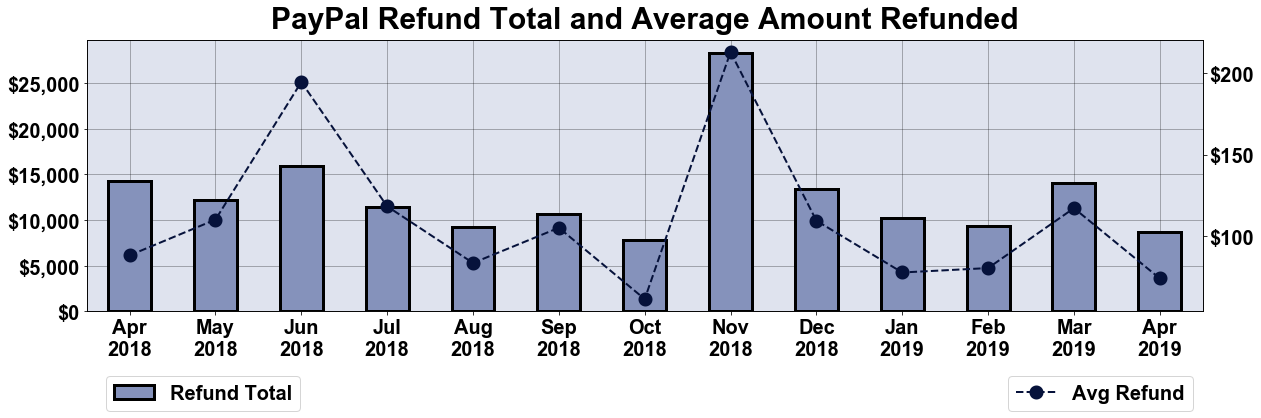

In [42]:
fig, ax = plt.subplots(figsize = (20,5))

refunds[['amount refunded']].plot(kind = 'bar',
                             ax = ax,
                             color = colors[2],
                             lw = 3,
                             edgecolor = 'black',
                             zorder = 5)

ax.set_title('PayPal Refund Total and Average Amount Refunded', y = 1.02)
ax.set_xlabel('')
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.set_facecolor(fc)
ax.legend(['Refund Total'], bbox_to_anchor = (0.2, -0.2))

ax2 = ax.twinx()
refunds[['avg amount refunded']].plot(color = colors[3], lw = 2, ls = '--', marker = 'o', mew = 8, ax = ax2)
ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
ax2.legend().set_visible(False)
ax2.legend(['Avg Refund'], bbox_to_anchor = (1, -0.2))
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Refunds for current month
See "CSP Monthly Chargeback/Fraud Report" for more on orders_statues
* Fraud - Void = stopped
* Fraud - Confirmed = not stopped

In [43]:
now = refunds_super_main[refunds_super_main['year and month payment pst'] == date_end[:7]].copy()
now.sort_values('csv gross', inplace = True)

ls = ['orders id','orders status name','billing status name']
for col in ls:
    now[col] = now['txn id'].map(dict(zip(pp_main['txn id'], pp_main[col])))
    
    

t1 = now['csv gross'].sum()
t2 = summary.iloc[-1]['amount refunded']

if np.abs(t1-t2) > 1:
    raise 0

print('${:,.0f} refunded during {}'.format(np.abs(t1), jb_dates(pd.Series(date_end[:7]), 'year and month pretty')[0]))

now['orders id'].fillna(0, inplace = True)
now['orders id'] = now['orders id'].map(int)

ls = ['orders id','csv gross','orders status name','billing status name']
fmt = [0,'m2',0,0]
now[ls].head(10).format_(fmt)

$8,683 refunded during Apr 2019


,Orders Id,Csv Gross,Orders Status Name,Billing Status Name
189390,2043525,$-785.40,voided,refunded
185565,2019381,$-728.60,return,refunded
189515,2041517,$-436.84,voided,refunded
185665,2005153,$-378.73,fraud - void,charged
184101,2025652,$-361.24,voided,refunded
185843,2002302,$-269.40,return,refunded
183319,2020719,$-206.93,voided,refunded
184544,2027472,$-189.69,voided,refunded
185926,2032146,$-178.86,voided,refunded
184998,2028708,$-171.15,voided,refunded


### For report: current refunds

In [44]:
oids = now.iloc[:3]['orders id'].tolist()
totals = now.iloc[:3]['csv gross'].tolist()
totals = [np.abs(x) for x in totals]

link = 'https://volcano.adafruit.com/volcano/Order_Status.php?oid='

for i in range(3):
    report_dict['refund oid ' + str(i)] = str(oids[i])
    report_dict['refund link ' + str(i)] = link + str(oids[i])
    report_dict['refund amount ' + str(i)] = '${:,.0f}'.format(totals[i])

### Chargebacks and Reversals

In [45]:
main = other_debits_main[other_debits_main['type'].isin(['payment reversal','chargeback'])].copy()
df1 = main.groupby(['year and month payment pst','type'])[['csv gross']].sum().unstack(1)
df1.columns = df1.columns.droplevel(0)

df2 = ym.join(df1).fillna(0)

df2.format_(['m0'] * 2)

,Chargeback,Payment Reversal
year and month,,
2018-04,$0,$-61
2018-05,$0,$-30
2018-06,$-97,$-145
2018-07,$0,$-163
2018-08,$-209,$0
2018-09,$0,$0
2018-10,$0,$0
2018-11,$-624,$0
2018-12,$0,$0


### Payment types by count

In [46]:
pay = pd.read_sql(
'''
SELECT
DATE_FORMAT(date_purchased, '%Y-%m') AS year_and_month,
payment_method
FROM orders
WHERE DATE(date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND orders_status NOT IN (9,11,12,13,14,15)
''', db)

col_fix(pay)

In [47]:
pay['payment method'] = np.where(pay['payment method'].str.contains('Purchase Order'), 'Purchase Order', pay['payment method'])

pay2 = pay.groupby(['year and month','payment method'])[['payment method']].count().unstack(1).fillna(0)
pay2.columns = pay2.columns.get_level_values(1)
pay2.sort_values(pay2.index[-1], 
                 ascending = False, 
                 axis = 1,
                 inplace = True)

pay3 = pay2.iloc[[-1]].T

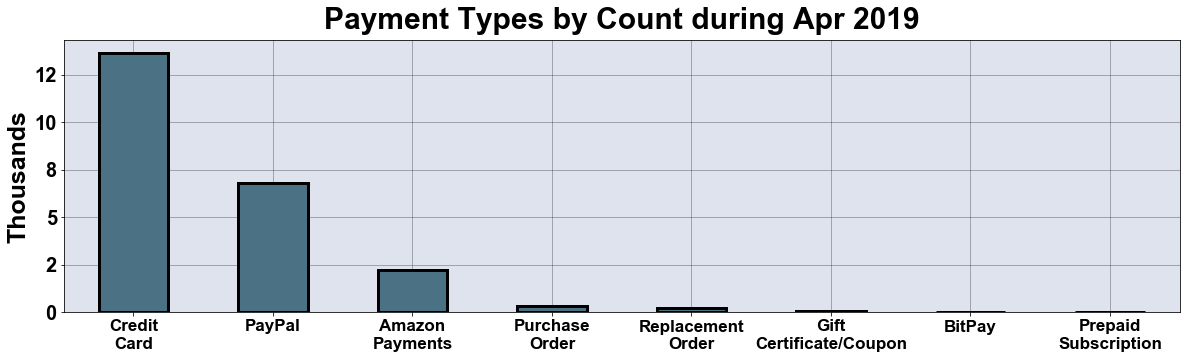

In [48]:
fig, ax = plt.subplots(figsize = (20,5))

xticks = pay3.index
xticks = [x.replace(' ','\n') for x in xticks]

d = date_end
m = calendar.month_abbr[int(d[5:7])]
y = d[:4]
d2 = m + ' ' + y

pay3.plot(kind = 'bar', 
          ax = ax, 
          edgecolor = 'black',
          color = colors[1], 
          zorder = 5,
          lw = 3)

ax.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ax.get_yticks()])
ax.set_ylabel('Thousands')
ax.set_xticklabels(xticks, rotation = 0, fontsize = 17)
ax.set_xlabel('')
ax.set_title('Payment Types by Count during %s' % d2, y = 1.02)
ax.set_facecolor(fc)
ax.legend().set_visible(False)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title()[:22], bbox_inches = 'tight')
plt.show()

### For report: rank

In [49]:
rank = pay3.index.get_loc('PayPal') + 1

if rank == 1:
    ret = 'first'
elif rank == 2:
    ret = 'second'
elif rank == 3:
    ret = 'third'
elif rank == 4:
    ret = 'fourth'
elif rank == 5:
    ret = 'fifth'    
    
report_dict['rank'] = ret
report_dict['rank']

'second'

### PDF report

In [50]:
year_and_month = calendar.month_abbr[int(date_end[5:7])] + ' ' + date_end[:4]
report_title = date_end[:4] + ' - ' + date_end[5:7] + ' - ' + calendar.month_abbr[int(date_end[5:7])] + ' - PayPal Monthly Audit'

### For report: summary

In [51]:
a = revenue['total'].pct_change(periods = 12).iloc[-1]
w1 = 'PayPal revenue {} {:,.0f}% year over year;'.format('decreased' if a < 0 else 'increased',
                                                        np.abs(a) * 100)

a = revenue['avg order value'].pct_change(periods = 12).iloc[-1]
if a < 0.01:
    res = 'remained the same'
else:
    if a < 0:
        res = 'fell {:,.0f}%'.format(np.abs(a) * 100)
    else:
        res = 'rose {:,.0f}%'.format(np.abs(a) * 100)
w2 = 'the average order value {} year over year;'.format(res)
a = fees.iloc[-1]['fees as % of amount received']
b = fees['fees as % of amount received'].mean()

if np.abs(a-b) < 0.02:
    res = 'in-line with'
else:
    if a < b:
        res = 'less than'
    else:
        res = 'greater than'
    
w3 = 'fees were {} past months;'.format(res)

a = refunds['amount refunded'].pct_change(periods = 12).iloc[-1]
w4 = 'total amount refunded was {} {:,.0f}% year over year;'.format('down' if a < 0 else 'up',
                                                                   np.abs(a) * 100)

a = refunds['avg amount refunded'].pct_change(periods = 12).iloc[-1]
w5 = 'average amount refunded was {} {:,.0f}% year over year;'.format('down' if a < 0 else 'up',
                                                                       np.abs(a) * 100)

a = revenue.iloc[-1]['paypal total as % of monthly total']
w6 = 'PayPal revenue made up {:,.0f}% of total monthly revenue.'.format(a * 100)

write = ' '.join([w1,w2,w3,w4,w5,w6])
report_dict['summary write'] = write
report_dict['summary write']

'PayPal revenue decreased 12% year over year; the average order value remained the same year over year; fees were in-line with past months; total amount refunded was down 39% year over year; average amount refunded was down 16% year over year; PayPal revenue made up 20% of total monthly revenue.'

In [54]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'year_and_month':year_and_month,
                     'now':now_pretty,
                     'summary_write':report_dict['summary write'],
                     'revenue_write':report_dict['revenue write'],
                     'proportion_write':report_dict['proportion write'],
                     'aov_write':report_dict['aov write'],
                     'fees_write':report_dict['fees write'],
                     'total_refund_write':report_dict['total refund write'],
                     'avg_refund_write':report_dict['avg refund write'],
                     
                     'refund_link_0':report_dict['refund link 0'],
                     'refund_link_1':report_dict['refund link 1'],
                     'refund_link_2':report_dict['refund link 2'],
                    
                     'refund_oid_0':report_dict['refund oid 0'],
                     'refund_oid_1':report_dict['refund oid 1'],
                     'refund_oid_2':report_dict['refund oid 2'],
                    
                     'refund_amount_0':report_dict['refund amount 0'],
                     'refund_amount_1':report_dict['refund amount 1'],
                     'refund_amount_2':report_dict['refund amount 2'],
                     
                     'rank':report_dict['rank']}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [55]:
print('done')

done
